# Cancer Subtype Prediction using Gene Expression Data

## Project structure
0) Plan
1) Importing the libraries and reading the data
2) Checking examples and statistics
3) Performing EDA
4) Data engineering & Model creation
5) Conclusion
6) Improvment plan
7) Bibliography

### 0) Plan

This is a brief initial plan for conducting the project that recapitulates the main ideas adopted while carrying out the design and implementation.

- Data preprocessing : 

First, understand the problem. Then, check which format the data is in, check for missing values and dataset statistics.

- Exploratory data analysis (EDA) :

Take a deep dive into the data : What information does the data contain? What relations exist between the features themselves? between the features and the target variable?

- Data engineering :

This dataset is obtained using the Microarray technology. This technology is known for carrying background noise [2]. Therefore, it can be interesting to eliminate this noise (outliers for example).

Selecting a subset of features is also important since there are a lot of features (+20k) which are not all informative. We prefer using feature selection over dimensionality reduction to avoid creating new features that do not have a technical significance in genetics.

- Modeling :

Use a model that is not sensitive to outliers such as ensemble methods to mitigate the Microarray limitation.
Since the dataset is small, we can train multiple models at once and keep the best performing one.


### 1) Importing the libraries and reading the data


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [46]:
df = pd.read_csv('Data/train.csv', index_col=0)

### 2) Checking data examples and statistics

In [47]:
df.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
88,GSM139466.CEL.gz,Ovarian_Tumor_Serous,10.657338,7.334390,6.008316,11.110976,4.369533,8.405554,5.394035,5.132351,...,4.420118,5.289211,12.830594,12.903713,4.690083,4.282668,4.141177,3.923703,4.111312,4.094231
23,GSM139400.CEL.gz,Ovarian_Tumor_Endometrioid,11.491874,6.683240,5.902034,10.236538,4.421190,7.685912,5.674513,5.128294,...,4.600560,5.540428,13.295688,13.478680,4.813273,4.386874,4.218702,3.986668,4.155982,4.076248
48,GSM139426.CEL.gz,Ovarian_Tumor_Mucinous,10.314452,6.495305,6.067844,8.932200,4.313781,7.720813,5.557916,5.193771,...,4.753995,5.827996,13.434393,13.707801,4.901715,4.456844,4.249358,4.043522,4.229169,4.102726
14,GSM139391.CEL.gz,Ovarian_Tumor_Endometrioid,10.513461,6.422066,6.011060,9.872251,4.256327,7.600642,5.542977,4.997941,...,4.625638,5.529046,13.135787,13.222189,4.791806,4.283359,4.063190,3.921959,4.149170,4.063612
63,GSM139441.CEL.gz,Ovarian_Tumor_Serous,10.974670,7.051280,5.961062,10.835584,4.279674,8.352425,5.664856,5.197727,...,4.754682,5.958735,12.359415,11.651661,5.044779,4.474342,4.202246,4.020624,4.276949,4.062319


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 88 to 32
Columns: 22285 entries, samples to AFFX-TrpnX-M_at
dtypes: float64(22283), object(2)
memory usage: 13.3+ MB


#### The data contains 78 samples, each having 22283 genes, an overian cancer subtype and a sample id

In [49]:
df.isnull().sum()

samples            0
type               0
1007_s_at          0
1053_at            0
117_at             0
                  ..
AFFX-ThrX-5_at     0
AFFX-ThrX-M_at     0
AFFX-TrpnX-3_at    0
AFFX-TrpnX-5_at    0
AFFX-TrpnX-M_at    0
Length: 22285, dtype: int64

#### There are no null values in the dataset

In [50]:
df.nunique()

samples            78
type                4
1007_s_at          78
1053_at            78
117_at             78
                   ..
AFFX-ThrX-5_at     78
AFFX-ThrX-M_at     78
AFFX-TrpnX-3_at    78
AFFX-TrpnX-5_at    78
AFFX-TrpnX-M_at    78
Length: 22285, dtype: int64

In [51]:
set(df.nunique().values)

{np.int64(4),
 np.int64(73),
 np.int64(74),
 np.int64(75),
 np.int64(76),
 np.int64(77),
 np.int64(78)}

#### There are indeed 4 types of ovarian cancer as specified in the problem statement
#### There are different values for every gene per sample (almost always as many values as samples) which is to be expected given that these are continuous values that represent a gene's expression (activity)

In [52]:
df['type'].unique()

array(['Ovarian_Tumor_Serous', 'Ovarian_Tumor_Endometrioid',
       'Ovarian_Tumor_Mucinous', 'Ovarian_Tumor_ClearCel'], dtype=object)

#### Let us see how many samples there is per type

In [63]:
df.groupby('type').size()

type
Ovarian_Tumor_ClearCel         6
Ovarian_Tumor_Endometrioid    29
Ovarian_Tumor_Mucinous        10
Ovarian_Tumor_Serous          33
dtype: int64

#### There is a slight class imbalance, especially for the "clear cell", but given the size of the dataset it is not that significant

In [53]:
gene_names = [gene for gene in df.columns if gene != 'type' and gene != 'samples']

In [54]:
X = df[gene_names]
y = df['type'].values
types = df['type'].unique()
assert len(y) == len(X)

### 3) Performing EDA

<Axes: >

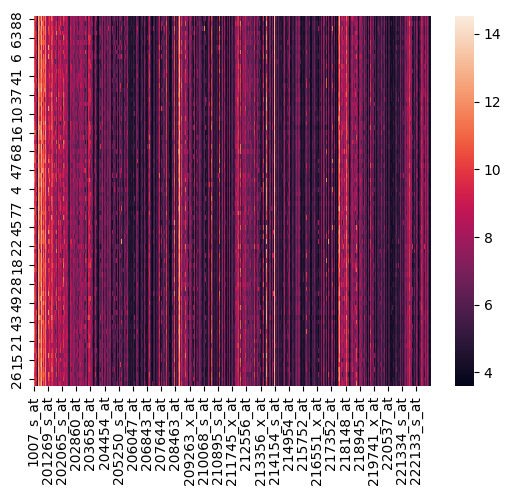

In [55]:
sns.heatmap(X)

#### We can clearly see corelations between the different genes
#### This remark confirms the following statement : 
"Other diseases are influenced by genetics, but the genes a person gets from their parents only change their risk of getting a disease. Most of these diseases are inherited in a complex way, with either multiple genes involved, or coming from both genes and the environment." [7]

#### This insinuates that there are specific genes that might cause specific types of ovarian cancer.

#### To confirm this, let us take a closer look at the first 20 genes of the first 20 samples

<Axes: >

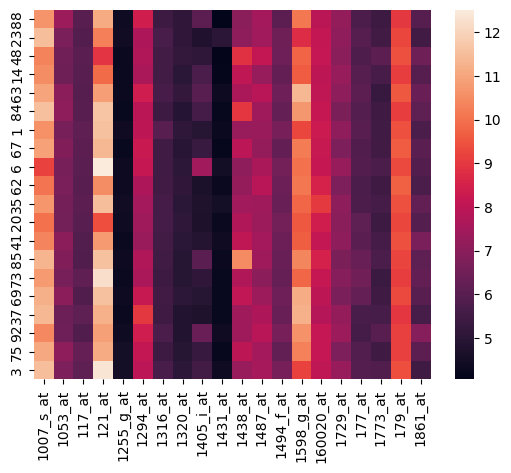

In [56]:
sns.heatmap(X[X.columns.values[:20]][:20])

#### We can now see more clearly these correlations. However, we cannot make any conclusions since performing an EDA on 20k+ features is not visually informative.

#### The presence of correlations gives us valuable insights :
##### There are important correlations between the features which means that we can use less features to train our model.

### Let us check if there are any distribution similarities between some examples of the dataset

In [62]:
pd.pivot_table(df, index = 'type', values = X.columns[:10], aggfunc = 'mean')

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at
type,,,,,,,,,,
Ovarian_Tumor_ClearCel,10.194808,6.662571,6.047250,11.851596,4.413169,8.010221,5.744046,5.060157,6.025045,4.338529
Ovarian_Tumor_Endometrioid,10.567949,6.711782,6.050898,10.717645,4.320064,8.034135,5.552443,5.025869,5.223668,4.301988
Ovarian_Tumor_Mucinous,10.731804,6.477752,6.000054,9.667768,4.335330,8.232681,5.614922,5.090098,5.456882,4.277196
Ovarian_Tumor_Serous,10.981506,6.797305,6.146528,11.023967,4.331611,8.069757,5.531191,5.061754,5.496498,4.285198


#### The mean gene expression values tend to vary differently. For example, the gene 1007_s_at the expression values increase from clear cell, endometroid, mucinous, to serous. However, It has almost the opposit evolution for the gene 121_at

#### Let us check the distribution of the first 4 gene expression following the cancer type

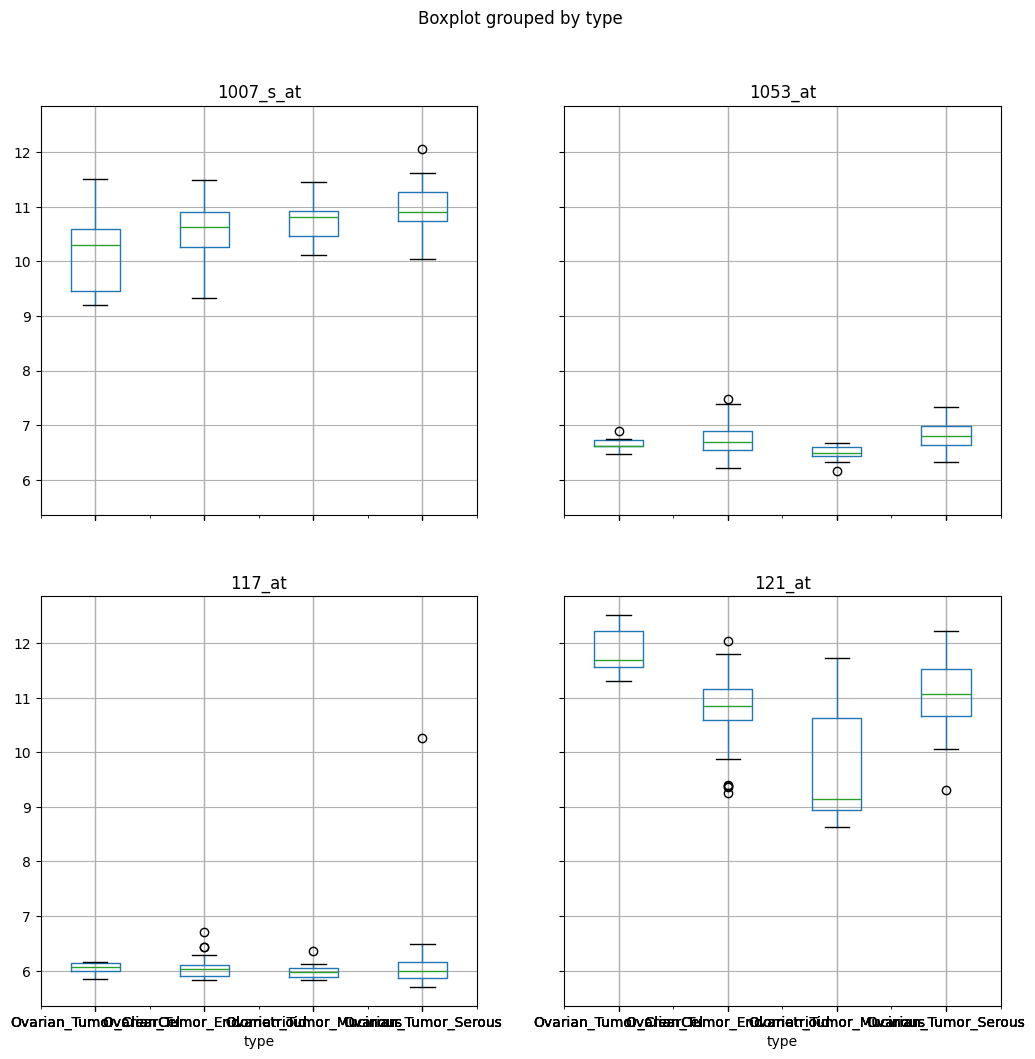

In [60]:
df.boxplot(column = gene_names[:4] , by = 'type', figsize=(12, 12))
plt.show()

#### There are different distributions for the gene expression values checked per cancer type. This is a good sign since it means that some genes have different expressions that vary depanding on the cancer type

## EDA Conclusion : 

- There are correlations between gene expressions => Some features can be removed

- There are differences in gene expression distributions => The expressions can be helpful to differentiate between the cancer types

## 4) Data engineering & Model creation
- We do not need to handle any missing features since all the values are not null.
- The Microarray techniques tend to be error prone, outlier detection can be interesting. However, since we do not have an expert, it is better to keep all the values nad use a model that is not sensitive to outliers.
- We can also remove some features since there are correlations between them.

Therefore, we will focus in this section on obtaining less features to feed our model.

### Feature engineering

Typically, we either select a subet of features (feature selection) or transform the set of features to a lower dimension set (dimensionality reduction). 

In this scenario, using dimensionality reduction techniques such as PCA or T-SNE can result in better classification results but we will lose the initial features significance. This will limit the interpretability of the results since we will not be able to clearly identify which genes are responsable for the results obtained.

Additionally, it is known that the possibility of getting cancer can be traced back to specific genes. This means that there is a subset of features that can be informative to our model in the prediction task. Therefore, we will use feature selection to obtain a samller set of genes that are maximally informative.

In theory, the genes responsible for the cancer types should be the same regardless of the model used. Consequently, we choose to experiment with two feature selection approaches : filter and embedded.

Wrapper approaches for feature selection are costly to use and they take into account the model used, that is why we decided to not use them for now.

## A) The filter method

We use one commonly used feature importance metric : Information Gain (IG)

Information Gain (or Kullback–Leibler divergence) computes the amount of information gained about a random variable or signal from observing another random variable (in our case gene expressions).

Information Gain has solid foundations in information theory and it seems to be more adapted since it is not based on correlation or variance which are both impacted by noise.

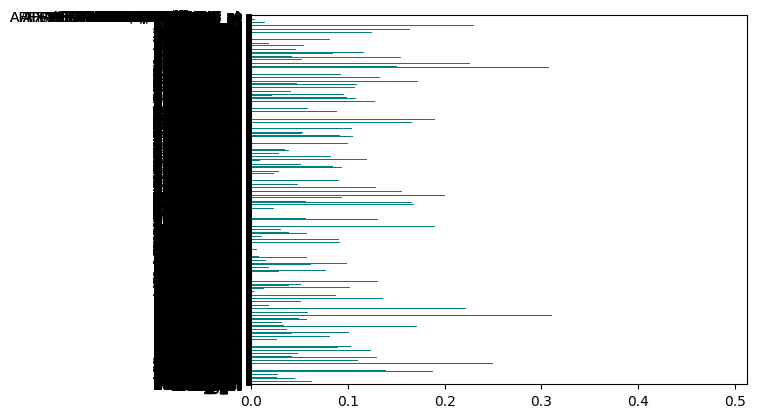

In [128]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt

# Computing importance using IG
importances = mutual_info_classif(X, y)

# Retrieving the IG scores and plotting for every gene its IG
feat_importances = pd.Series(importances, X.columns)
feat_importances.plot(kind='barh', color = 'teal')
plt.show()

In [129]:
# Sorted list of gene expressions following their information gain values
feat_importances.sort_values(ascending = False).head(500)

217984_at      0.488838
205313_at      0.482410
201301_s_at    0.467043
209173_at      0.439591
205799_s_at    0.436206
                 ...   
213158_at      0.228245
200924_s_at    0.227935
216372_at      0.227852
214088_s_at    0.227790
201734_at      0.227737
Length: 500, dtype: float64

In [135]:
# We consider the top 1000 genes following their information gain
important_features = feat_importances.sort_values(ascending=False).head(1000).index.values

#### We opted for SVM since its a model that works well with small datasets 
#### Despite being sensitive to outliers which is the case here since Microarray data contain noise, the use of SVM should not be a problem since we perfomed feature selection thus reducing noise

In [136]:
# Use an SVM classifier to predict the cancer types using only the features selected
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


# Create an SVM classifier 
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))
X_reduced = X[important_features]

# Fit the model to the data
model.fit(X_reduced, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [137]:
# Load the test file
df_test = pd.read_csv('Data/test.csv', index_col = 0)
df_test.head()

,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
2,GSM139379.CEL.gz,Ovarian_Tumor_ClearCel,9.965433,5.985501,5.934106,11.450878,4.531086,8.132967,5.674546,4.905562,...,4.422940,5.101742,12.676774,12.121132,4.807272,4.250548,4.212394,4.080735,4.152480,4.149600
95,GSM139473.CEL.gz,Ovarian_Tumor_Serous,10.409115,6.828334,5.824865,10.740165,4.362750,7.773209,5.539237,5.240613,...,4.783151,5.893559,12.694608,12.184063,5.003979,4.432284,4.216210,4.004154,4.383120,4.307563
19,GSM139396.CEL.gz,Ovarian_Tumor_Endometrioid,10.329271,7.017162,5.921843,10.524740,4.296693,8.067781,5.552618,5.018155,...,4.576997,5.717107,13.395747,13.498504,4.904752,4.393962,4.185619,3.972211,4.157963,4.152601
40,GSM139417.CEL.gz,Ovarian_Tumor_Endometrioid,10.130511,6.164366,5.881440,9.663632,4.371584,8.030204,5.691863,5.243910,...,4.338367,5.774157,12.717617,12.273596,4.917590,4.342942,4.207619,4.093228,4.225025,4.196922
44,GSM139421.CEL.gz,Ovarian_Tumor_Endometrioid,10.513373,6.370582,5.855983,10.522540,4.294194,7.777619,5.464102,4.990287,...,4.425628,5.415099,12.536751,12.029308,4.812089,4.333665,4.205790,3.956694,4.191278,4.213071


In [138]:
# Prepare the variables needed for testing
X_test = df_test[important_features]
Y_test = df_test['type'].values
assert len(X_test) == len(Y_test)
Y_pred = model.predict(X_test)

In [139]:
from sklearn.metrics import accuracy_score, f1_score, precision_score

print("Accuracy score on test : ", accuracy_score(Y_test, Y_pred))
print("Weighted F1 score on test : ", f1_score(Y_test, Y_pred, average = "weighted"))
print("Weighted Precision score on test : ", precision_score(Y_test, Y_pred, average = "weighted"))

Accuracy score on test :  0.8
Weighted F1 score on test :  0.7892230576441103
Weighted Precision score on test :  0.8242424242424242


## With no filter

Now, we redo the same process without feature selection to check if it has improved the results

In [143]:
# Create an SVM classifier 
model = make_pipeline(StandardScaler(), SVC(gamma='auto'))

# Fit the model to the data
model.fit(X, y)

X_test = df_test[gene_names]
Y_test = df_test['type'].values
assert len(X_test) == len(Y_test)
Y_pred = model.predict(X_test)

print("Accuracy score on test : ", accuracy_score(Y_test, Y_pred))
print("Weighted F1 score on test : ", f1_score(Y_test, Y_pred, average = "weighted"))
print("Weighted Precision score on test : ", precision_score(Y_test, Y_pred, average = "weighted"))

Accuracy score on test :  0.65
Weighted F1 score on test :  0.6
Weighted Precision score on test :  0.5952380952380952


/home/abazouzi/Documents/Code/CancerSubtype/cancersubtype/lib64/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Discussion

As expected, using only an informative subset of features has sped up the training and improved the results.

Taking into account all the features can deteriorate the results especially for a model that is sensitive to outliers like SVM.

## B) The embedded method

We use a model that automatically choses the features it takes into account. The model chosen is the random forest classifier.

Being an ensemble method, random forest has tolerance for outliers since it classifies using multiple decision trees that are trained on multiple subsets of the data which makes the model robust.

The features chosen are also given importance scores computed by the model itself.

<Axes: >

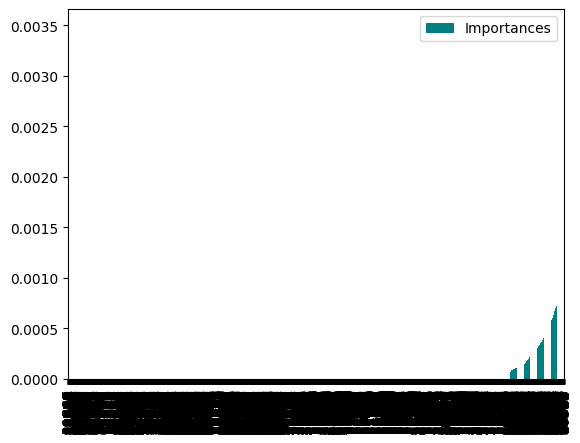

In [140]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest classifier
model = RandomForestClassifier(n_estimators=300)

# Fit the model to the data
model.fit(X, y)

# Get the importance of the resulting features
importances = model.feature_importances_

# Create a dataframe for visualization
final_df = pd.DataFrame({'Features': pd.DataFrame(X).columns, 'Importances': importances})
final_df.set_index('Importances')

# Sort in ascending order for better visualization
final_df = final_df.sort_values('Importances')

# Plot the feature importances in bars
final_df.plot.bar(color='teal')

In [141]:
X_test = df_test[gene_names]
Y_test = df_test['type'].values
assert len(X_test) == len(Y_test)
Y_pred = model.predict(X_test)
print("Accuracy score on test : ", accuracy_score(Y_test, Y_pred))
print("Weighted F1 score on test : ", f1_score(Y_test, Y_pred, average = "weighted"))
print("Weighted Precision score on test : ", precision_score(Y_test, Y_pred, average = "weighted"))

Accuracy score on test :  0.75
Weighted F1 score on test :  0.7368421052631579
Weighted Precision score on test :  0.7766233766233767


## Discussion

After having tried two feature selection methods, it is clear that SVM with filter feature selection works better.
When feeding SVM features that contain minimal noise, it can outperform random forests in these evaluation settings.

# 5) Conclusion
In this notebook, we have analyzed the problem of cancer subtype classification using gene expression. We started by reading about genetics to better understand the problem, some of the concepts studied are : genes, gene profiling with ADN Microarry and RNA sequencing, and the relation between genetics and diseases.

We took a closer look at the dataset and performed exploratory data analysis and came up with two conclusions : some gene expressions are correlated and gene expression distributions are different.

Taking these two conclusions into account we proposed conducting feature engineering to obtain a subset of gene expressions to feed a model. We used two approaches : Filter methods and embedded methods. Filter methods using information gain and SVMs showed to perform better than random forests (embedded methods). However, this is not a conclusive result, more methods should be tested before drawing conclusions.

# 6) Improvment plan 

## Design

- Read more about the used methods and try some of the models used : Neural Networks, Autoencoders, etc [1-6].
- Opt for a method that is not sensitive to outliers.
- Since the dataset is small, we can run multiple methods and keep the model with the best performance.
- Run the models on different subsets of the gene expressions and find the optimal subset.
- Think more about which metrics should be used to evaluate the results.
- Use Cross validation to evaluate the models and use grid search to search for the best parameters and hyperparameters.

## Implementation

- Modularize and structure the project by ceating different files for the models, data ingestion, data transformation, logging, exception handeling, etc. Then, build a pipeline that can be directly deployed.

## 7) Bibliography
[1] L.-Y. Guo, A.-H. Wu, Y. Wang, L. Zhang, H. Chai, and X.-F. Liang, “Deep learning-based ovarian cancer subtypes identification using multi-omics data,” BioData Mining, vol. 13, no. 1, p. 10, Dec. 2020, doi: 10.1186/s13040-020-00222-x.

[2] F. Alharbi and A. Vakanski, “Machine Learning Methods for Cancer Classification Using Gene Expression Data: A Review,” Bioengineering, vol. 10, no. 2, Art. no. 2, Feb. 2023, doi: 10.3390/bioengineering10020173.

[3] A. El-Nabawy, N. El-Bendary, and N. A. Belal, “Epithelial Ovarian Cancer Stage Subtype Classification using Clinical and Gene Expression Integrative Approach,” Procedia Computer Science, vol. 131, pp. 23–30, Jan. 2018, doi: 10.1016/j.procs.2018.04.181.

[4] Md. A. Hossain, S. M. Saiful Islam, J. M. W. Quinn, F. Huq, and M. A. Moni, “Machine learning and bioinformatics models to identify gene expression patterns of ovarian cancer associated with disease progression and mortality,” Journal of Biomedical Informatics, vol. 100, p. 103313, Dec. 2019, doi: 10.1016/j.jbi.2019.103313.

[5] T. Vaiyapuri, Liyakathunisa, H. Alaskar, E. Aljohani, S. Shridevi, and A. Hussain, “Red Fox Optimizer with Data-Science-Enabled Microarray Gene Expression Classification Model,” Applied Sciences, vol. 12, no. 9, Art. no. 9, Jan. 2022, doi: 10.3390/app12094172.

[6] M. Mohammed, H. Mwambi, I. B. Mboya, M. K. Elbashir, and B. Omolo, “A stacking ensemble deep learning approach to cancer type classification based on TCGA data,” Scientific reports, vol. 11, no. 1, p. 15626, 2021.

[7] J. Peto, “Breast cancer susceptibility—A new look at an old model,” Cancer Cell, vol. 1, no. 5, pp. 411–412, Jun. 2002, doi: 10.1016/S1535-6108(02)00079-X.